# Analyze CSV data files with Vanna

world top companies
- https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide

## Setup

In [1]:
from glob import glob
import os
import re
from time import time
import warnings

import pandas as pd
import sqlite3

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

In [ ]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

### load SQLite db with CSV data

In [3]:
file_db_path = "../data/company_rank.sqlite"
file_db = os.path.abspath(os.path.expanduser(file_db_path))
print(file_db)

/home/papagame/projects/wgong/py4kids/lesson-18-ai/vanna/note_book/data/company_rank.sqlite


In [41]:
LOAD_CSV = True # False
if LOAD_CSV:
    csv_files = glob("../data/company_rank/*.csv")
    print(csv_files)
    
    conn = sqlite3.connect(file_db)
    df_dict = {}
    col_map = {}
    for i in csv_files:
        t = i.split("/")[-1].lower().replace("companies_ranked_by_","").replace(".csv","")
        df = pd.read_csv(i)
        c_map = {c:c.lower() for c in df.columns}
        c_map['price (GBP)'] = 'price_gbp'
        # print(f"col_map: {c_map}")
        table_name = f"t_{t}"
        print(f"Load '{i}' into table_name: '{table_name}'")
        col_map[table_name] = c_map
        df.rename(columns=c_map, inplace=True)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        df_dict[table_name] = df
    conn.close()

['../data/company_rank/Companies_ranked_by_Market_Cap.csv', '../data/company_rank/Companies_ranked_by_P_E_ratio.csv', '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv', '../data/company_rank/Companies_ranked_by_Earnings.csv', '../data/company_rank/country_region.csv', '../data/company_rank/Companies_ranked_by_Revenue.csv']
Load '../data/company_rank/Companies_ranked_by_Market_Cap.csv' into table_name: 't_market_cap'
Load '../data/company_rank/Companies_ranked_by_P_E_ratio.csv' into table_name: 't_p_e_ratio'
Load '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv' into table_name: 't_dividend_yield'
Load '../data/company_rank/Companies_ranked_by_Earnings.csv' into table_name: 't_earnings'
Load '../data/company_rank/country_region.csv' into table_name: 't_country_region'
Load '../data/company_rank/Companies_ranked_by_Revenue.csv' into table_name: 't_revenue'


In [42]:
# verify
VERIFY_DB = False # True # 
if VERIFY_DB:
    conn = sqlite3.connect(file_db)
    sql_stmt = f"select name from {table_name} limit 10"
    sql_stmt = """ 
    select country from t_revenue
     UNION 
    select country from t_earnings
     UNION 
    select country from t_market_cap
     UNION 
    select country from t_p_e_ratio
     UNION 
    select country from t_dividend_yield
    """
    df_2 = pd.read_sql_query(sql_stmt, conn).fillna("")
    country_list = df_2["country"].to_list()
    # print(df_2)
    conn.close()

In [43]:
country_list

['',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'British Virgin Islands',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Malaysia',
 'Malta',
 'Mexico',
 'Monaco',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay'

### Fix country

### Setup LLM

In [11]:
model_name = 'deepseek-coder-v2'
config = {
    'model': model_name,   # 'mistral' # "starcoder2"
}

clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [12]:
vn = MyVanna(config=config)

In [13]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [14]:
# file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [15]:
vn.run_sql_is_set

True

In [23]:
if clean_and_train:
    remove_collections()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [24]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [25]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,..."
1,table,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\..."
2,table,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE..."
3,table,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n..."
4,table,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ..."


In [33]:
tables = "t_revenue t_earnings t_market_cap t_p_e_ratio t_dividend_yield"
sql_stmts = []
for t in tables.split():
    sql_stmts.append(f"select country from {t}")
print("\n UNION \n".join(sql_stmts))

select country from t_revenue
 UNION 
select country from t_earnings
 UNION 
select country from t_market_cap
 UNION 
select country from t_p_e_ratio
 UNION 
select country from t_dividend_yield


In [26]:
business_docs = """
Introduction:
This dataset ranks top companies in the world.
Its analysis delves into the financial performance of top companies by examining key metrics such as revenue, earnings, market capitalisation, P/E ratio, and dividend yield. By comparing these metrics, we gain a comprehensive understanding of a company's scale, profitability, market value, and growth potential. Through visualisations, the analysis also explores correlations between these metrics and offers insights into country-level performance, highlighting economic dominance across various sectors. This holistic approach provides a multi-dimensional view of global financial powerhouses, investor confidence, and regional economic trends.

Key Metrics Used:
1. Revenue (Trailing Twelve Months - TTM):
Table Name: t_revenue ;
Definition: This is the total income generated by a company from its operations in the last twelve months ;
Potential Insights: High revenue often indicates market dominance or high sales volume. Comparing revenues can reveal which companies are the largest in terms of business volume.

2. Earnings (TTM):
Table Name: t_earnings
Definition: This refers to the company's profit after taxes and expenses over the trailing twelve months.
Potential Insights: Companies with high earnings are more efficient at converting revenue into profit, suggesting better profitability or cost management. A comparison of earnings provides insight into profitability rather than just scale.

3. Market Capitalisation (Market Cap):
Table Name: t_market_cap
Definition: Market cap is the total value of a company's outstanding shares of stock, calculated as stock price multiplied by the number of shares. It indicates the company’s size in the stock market.
Potential Insights: High market cap usually indicates investor confidence in the company. Comparing market cap among the top 15 companies reveals their relative size in financial markets.

4. P/E Ratio (TTM):
Table Name: t_p_e_ratio
Definition: Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings.
Potential Insights: A high P/E ratio may indicate that investors expect high growth in the future, while a low P/E ratio could imply undervaluation or scepticism about growth. Companies are compared by their growth prospects or current valuation.

5. Dividend Yield (TTM):
Table Name: t_dividend_yield
Definition: Dividend yield is a financial ratio that shows how much a company pays out in dividends each year relative to its share price.
Potential Insights: High dividend yield may indicate that a company returns more income to shareholders. It’s particularly useful for income-focused investors.

6. Country-Region Map:
Table Name: t_country_region
Definition: This table translate country to region
"""

In [27]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    # vn.train(documentation="In the chinook database invoice means order")
    vn.train(documentation=business_docs)


Adding ddl: CREATE TABLE "t_market_cap" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "marketcap" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_p_e_ratio" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "pe_ratio_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_dividend_yield" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "dividend_yield_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_earnings" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "earnings_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_revenue" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "revenue_ttm" INTEGER,
  "price_gbp" REAL,
  "country" TEXT
)
Adding documentation....


In [28]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,75de6b21-b3df-53ea-a36f-9af69e40913b-ddl,None,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ...",ddl
1,87669f00-5543-579a-a95c-fec096be48ed-ddl,None,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE...",ddl
2,b94bb579-73d6-521b-86de-5d5e599bbde5-ddl,None,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,...",ddl
3,e0a92066-0804-52fd-be4e-437ac10622de-ddl,None,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n...",ddl
4,f68c7d4a-806f-55f0-962d-74de7018e372-ddl,None,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\...",ddl
0,3ebd17c2-ffec-535e-8f59-f4a366d53b8d-doc,None,\nIntroduction:\nThis dataset ranks top compan...,documentation


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

In [29]:
ts_start = time()

```sql
SELECT name FROM sqlite_master WHERE type = 'table';
```


Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



# QUESTION - 2:  Can you list all tables in the SQLite database catalog?

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "sy

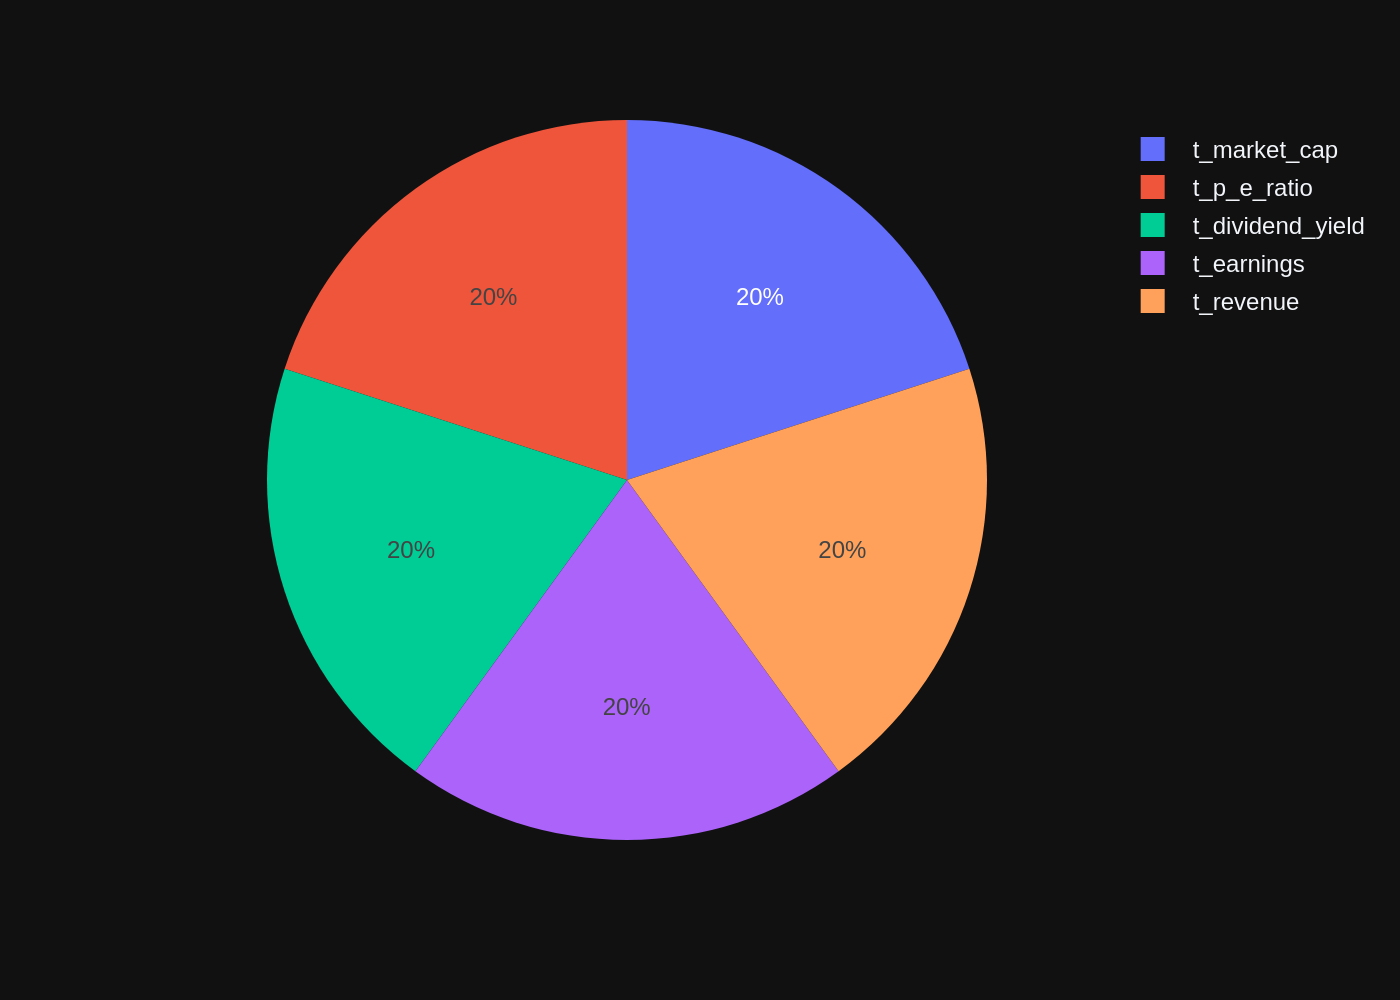

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



# QUESTION - 3:  which table stores Company P/E Ratio

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "div

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:12:02.802986267Z', 'message': {'role': 'assistant', 'content': " The table that stores a company's P/E ratio is `t_p_e_ratio`."}, 'done_reason': 'stop', 'done': True, 'total_duration': 39172159574, 'load_duration': 9519261, 'prompt_eval_count': 1121, 'prompt_eval_duration': 37066268000, 'eval_count': 23, 'eval_duration': 1931568000}
LLM Response:  The table that stores a company's P/E ratio is `t_p_e_ratio`.
 The table that stores a company's P/E ratio is `t_p_e_ratio`.
Couldn't run sql:  Execution failed on sql ' The table that stores a company's P/E ratio is `t_p_e_ratio`.': near "The": syntax error

# QUESTION - 4:  which table stores Company Dividend Yield

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructi

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:12:41.048813663Z', 'message': {'role': 'assistant', 'content': " The table that stores information about a company's dividend yield is `t_dividend_yield`."}, 'done_reason': 'stop', 'done': True, 'total_duration': 38135727797, 'load_duration': 9718463, 'prompt_eval_count': 1120, 'prompt_eval_duration': 36013734000, 'eval_count': 22, 'eval_duration': 1906367000}
LLM Response:  The table that stores information about a company's dividend yield is `t_dividend_yield`.
 The table that stores information about a company's dividend yield is `t_dividend_yield`.
Couldn't run sql:  Execution failed on sql ' The table that stores information about a company's dividend yield is `t_dividend_yield`.': near "The": syntax error

# QUESTION - 5:  which table stores Company Market Cap

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. You

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:13:19.114332281Z', 'message': {'role': 'assistant', 'content': ' intermediate_sql\nSELECT DISTINCT country FROM t_market_cap'}, 'done_reason': 'stop', 'done': True, 'total_duration': 38012588981, 'load_duration': 9307643, 'prompt_eval_count': 1119, 'prompt_eval_duration': 36429554000, 'eval_count': 14, 'eval_duration': 1324889000}
LLM Response:  intermediate_sql
SELECT DISTINCT country FROM t_market_cap
Running Intermediate SQL:  intermediate_sql
SELECT DISTINCT country FROM t_market_cap
Error running intermediate SQL: Execution failed on sql ' intermediate_sql
SELECT DISTINCT country FROM t_market_cap': near "intermediate_sql": syntax error
Couldn't run sql:  Execution failed on sql 'Error running intermediate SQL: Execution failed on sql ' intermediate_sql
SELECT DISTINCT country FROM t_market_cap': near "intermediate_sql": syntax error': near "Error": syntax error

# QUESTION - 6:  which table 

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:13:57.101945837Z', 'message': {'role': 'assistant', 'content': ' The table that stores Company Revenue is `t_revenue`.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 37945925703, 'load_duration': 9073009, 'prompt_eval_count': 1118, 'prompt_eval_duration': 36397847000, 'eval_count': 14, 'eval_duration': 1285806000}
LLM Response:  The table that stores Company Revenue is `t_revenue`.
 The table that stores Company Revenue is `t_revenue`.
Couldn't run sql:  Execution failed on sql ' The table that stores Company Revenue is `t_revenue`.': near "The": syntax error

# QUESTION - 7:  which table stores Company Earnings

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_ear

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:14:34.126873267Z', 'message': {'role': 'assistant', 'content': ' The table that stores company earnings information is `t_earnings`.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 36953621591, 'load_duration': 9854927, 'prompt_eval_count': 1119, 'prompt_eval_duration': 35468778000, 'eval_count': 15, 'eval_duration': 1270745000}
LLM Response:  The table that stores company earnings information is `t_earnings`.
 The table that stores company earnings information is `t_earnings`.
Couldn't run sql:  Execution failed on sql ' The table that stores company earnings information is `t_earnings`.': near "The": syntax error

# QUESTION - 8:  Find the customer with the most invoices 

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guideli

In [30]:
sql_id = 1

questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores Company P/E Ratio",
    "which table stores Company Dividend Yield",
    "which table stores Company Market Cap",
    "which table stores Company Revenue",
    "which table stores Company Earnings",
    "Find the customer with the most invoices ",
]

for question in questions:
    sql_id = my_vn_ask(question=question, sql_id=sql_id, allow_llm_to_see_data=allow_llm_to_see_data)

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



# QUESTION - 2:  What are the top 10 companies with the highest market cap around the world?

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n 

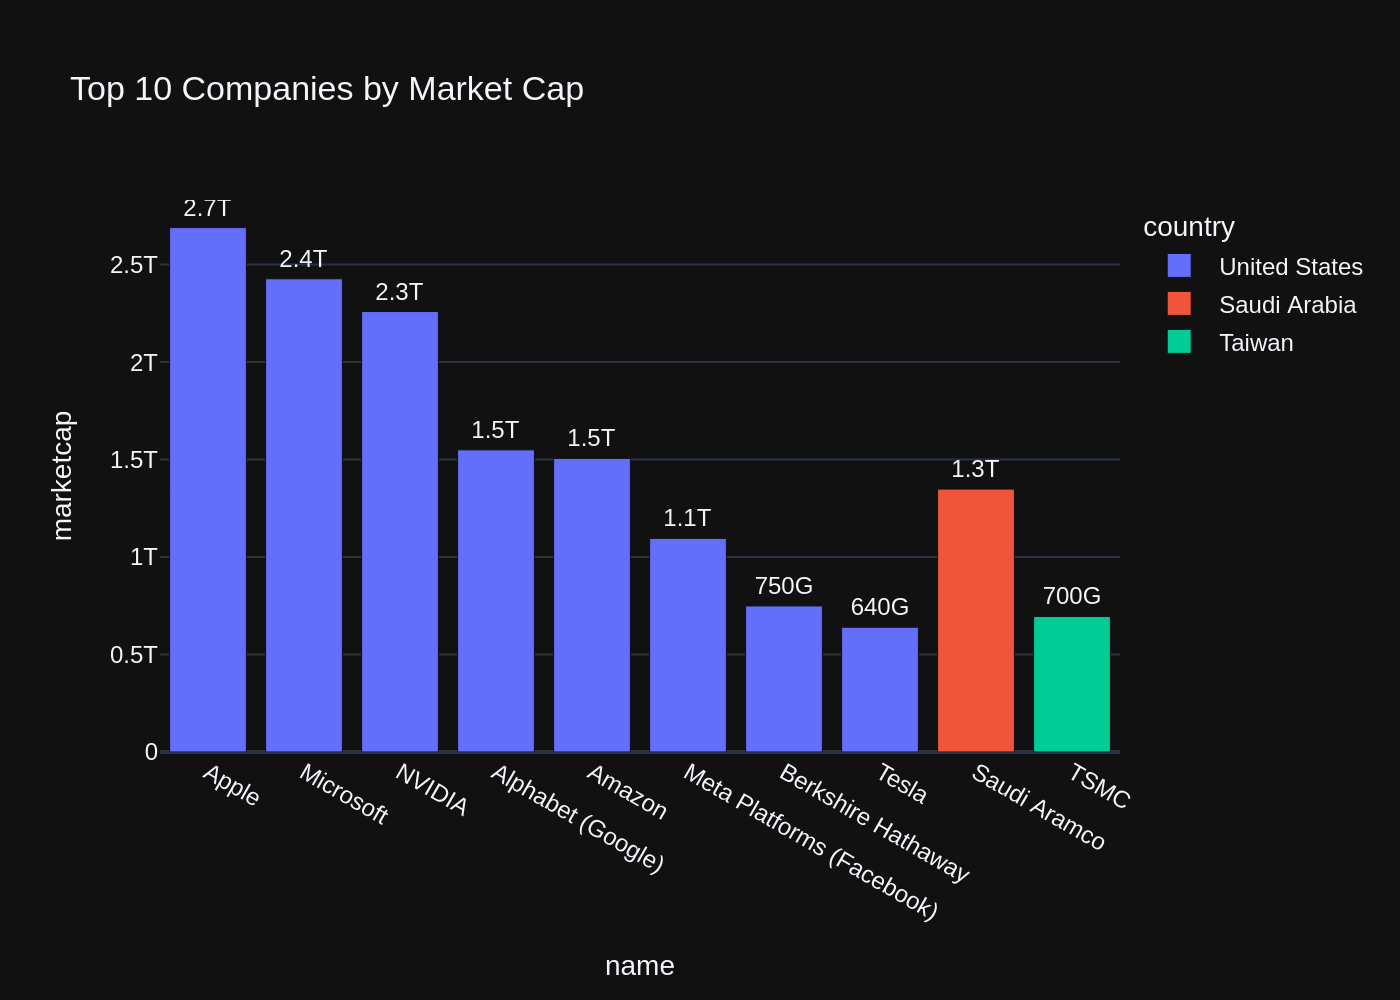

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1



# QUESTION - 3:  What are the top 10 companies with the highest market cap from USA?

SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "t_market_cap" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "marketcap" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_revenue" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "revenue_ttm" INTEGER,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_earnings" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "earnings_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_p_e_ratio" (\n"rank" INTEGER,\n  "name" TEXT,\n  "symbol" TEXT,\n  "pe_ratio_ttm" REAL,\n  "price_gbp" REAL,\n  "country" TEXT\n)\n\nCREATE TABLE "t_dividend_yield" (\n"rank" INTEGER,\n  "name" 

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Info: Ollama Response:
{'model': 'deepseek-coder-v2:latest', 'created_at': '2024-10-20T02:21:37.770223256Z', 'message': {'role': 'assistant', 'content': " intermediate_sql SELECT * FROM t_market_cap WHERE country = 'USA' ORDER BY marketcap DESC LIMIT 10"}, 'done_reason': 'stop', 'done': True, 'total_duration': 42266271409, 'load_duration': 9794965, 'prompt_eval_count': 1170, 'prompt_eval_duration': 39434723000, 'eval_count': 27, 'eval_duration': 2449587000}
LLM Response:  intermediate_sql SELECT * FROM t_market_cap WHERE country = 'USA' ORDER BY marketcap DESC LIMIT 10
Running Intermediate SQL:  intermediate_sql SELECT * FROM t_market_cap WHERE country = 'USA' ORDER BY marketcap DESC LIMIT 10
Error running intermediate SQL: Execution failed on sql ' intermediate_sql SELECT * FROM t_market_cap WHERE country = 'USA' ORDER BY marketcap DESC LIMIT 10': near "intermediate_sql": syntax error
Couldn't run sql:  Execution failed on sql 'Error running intermediate SQL: Execution failed on sql '

In [32]:
sql_id = 1

questions = [
    "What are the top 10 companies with the highest market cap around the world?",
    "What are the top 10 companies with the highest market cap from USA?",
    "What are the top 5 companies with the highest market cap from Asia?",
]

for question in questions:
    sql_id = my_vn_ask(question=question, sql_id=sql_id, allow_llm_to_see_data=allow_llm_to_see_data)

### Check completion time

In [31]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"Completed tests:\n================\n run on host '{hostname}' \n with LLM model '{model_name}' \n took {elapsed_time:.2f} sec")

Completed tests:
 run on host 'papa-game' 
 with LLM model 'deepseek-coder-v2' 
 took 462.93 sec
